# Employee Attrition

A dataset from https://www.kaggle.com/lnvardanyan/hr-analytics containing employee information of a company is provided.

The following variables are included in the data:

* satisfaction_level: The satisfaction of the employee
* last_evaluation: How long ago the employee had his last evaluation
* number_project: The amount of projects the employee has been involved in 
* average_montly_hours: The average amount of hours the employee works each month
* time_spend_company: The amount of years the employee has worked there
* Work_accident: Boolean representing if the employee has been involved in an accident
* left: Our target variable, determines if the employee left the company or not
* promotion_last_5years: Boolean on whether the employee was promoted in the last 5 years or not
* sales: The name of the department the employee works in
* salary: The salary of the employee (can be low, medium or high)

We want to build a classification model that can determine which employee will likely leave the company in order to make the necessary changes to reduce employee attrition. We will use 80% of the data for training and the remaining 20% for validation of our modeling.

### Outline

We separate the project in 3 steps:

Data Loading and Exploratory Data Analysis: Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. Also, the creation of different types of plots in order to help us understand the data and make the model creation easier.

Feature Engineering / Modeling and Pipeline: Once we have the data, we create some features and then the modeling stage begins, making use of different models (and ensembles) and a strong pipeline with different transformers, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

Results and Conclusions: Finally, with our tuned model, we  predict against the test set we decided to separate initially, then we review those results against their actual values to determine the performance of the model, and finally, outlining our conclusions.

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tempfile import mkdtemp
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from ml_helper.helper import Helper
from imblearn import FunctionSampler
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from gplearn.genetic import SymbolicTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectFromModel
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score as metric_scorer, classification_report
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, PowerTransformer, OneHotEncoder, FunctionTransformer

# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed.

In [3]:
MEMORY = mkdtemp()

KEYS = {
    'SEED': 1,
    'DATA_PATH' : 'https://gist.githubusercontent.com/akoury/d5943d9c3dba8dc20a4c0c35027b110c/raw/8f01edb1ce950511cab5f9aa6aafd14bd2fe96db/Turnover',
    'TARGET': 'left',
    'METRIC': 'accuracy',
    'TIMESERIES': False,
    'SPLITS': 5,
    'ESTIMATORS': 150,
    'ITERATIONS': 500,
    'MEMORY': MEMORY
}

hp = Helper(KEYS)

### Data Loading

Here we load the necessary data, print its first rows and describe its contents.

In [3]:
def read_data(input_path):
    return pd.read_csv(input_path)

data = read_data(KEYS['DATA_PATH'])

data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Data types

We review the data types for each column.

In [5]:
data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

### Missing Data

We check if there is any missing data.

In [6]:
hp.missing_data(data)

,Total,Percent
salary,0,0.0
sales,0,0.0
promotion_last_5years,0,0.0
left,0,0.0
Work_accident,0,0.0
time_spend_company,0,0.0
average_montly_hours,0,0.0
number_project,0,0.0
last_evaluation,0,0.0
satisfaction_level,0,0.0


### Converting columns to their true categorical type
Now we convert the data types of numerical columns that are actually categorical.

In [7]:
data = hp.convert_to_category(data, data.iloc[:,5:8])

data.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident            category
left                     category
promotion_last_5years    category
sales                      object
salary                     object
dtype: object

### Defining Holdout Set for Validation

80% of the data will be used to train our model, while the remaining data will be used later on to validate the accuracy of our model.

In [8]:
train_data, holdout = train_test_split(data, test_size=0.2)

## Exploratory Data Analysis

Here we will perform all of the necessary data analysis, with different plots that will help us understand the data and therefore, create a better model.

We must specify that all of this analysis is performed only on the training data, so that we do not incur in any sort of bias when modeling.

We begin by plotting pairwise relationships between variables, as well as the distribution for each column in the diagonal.

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


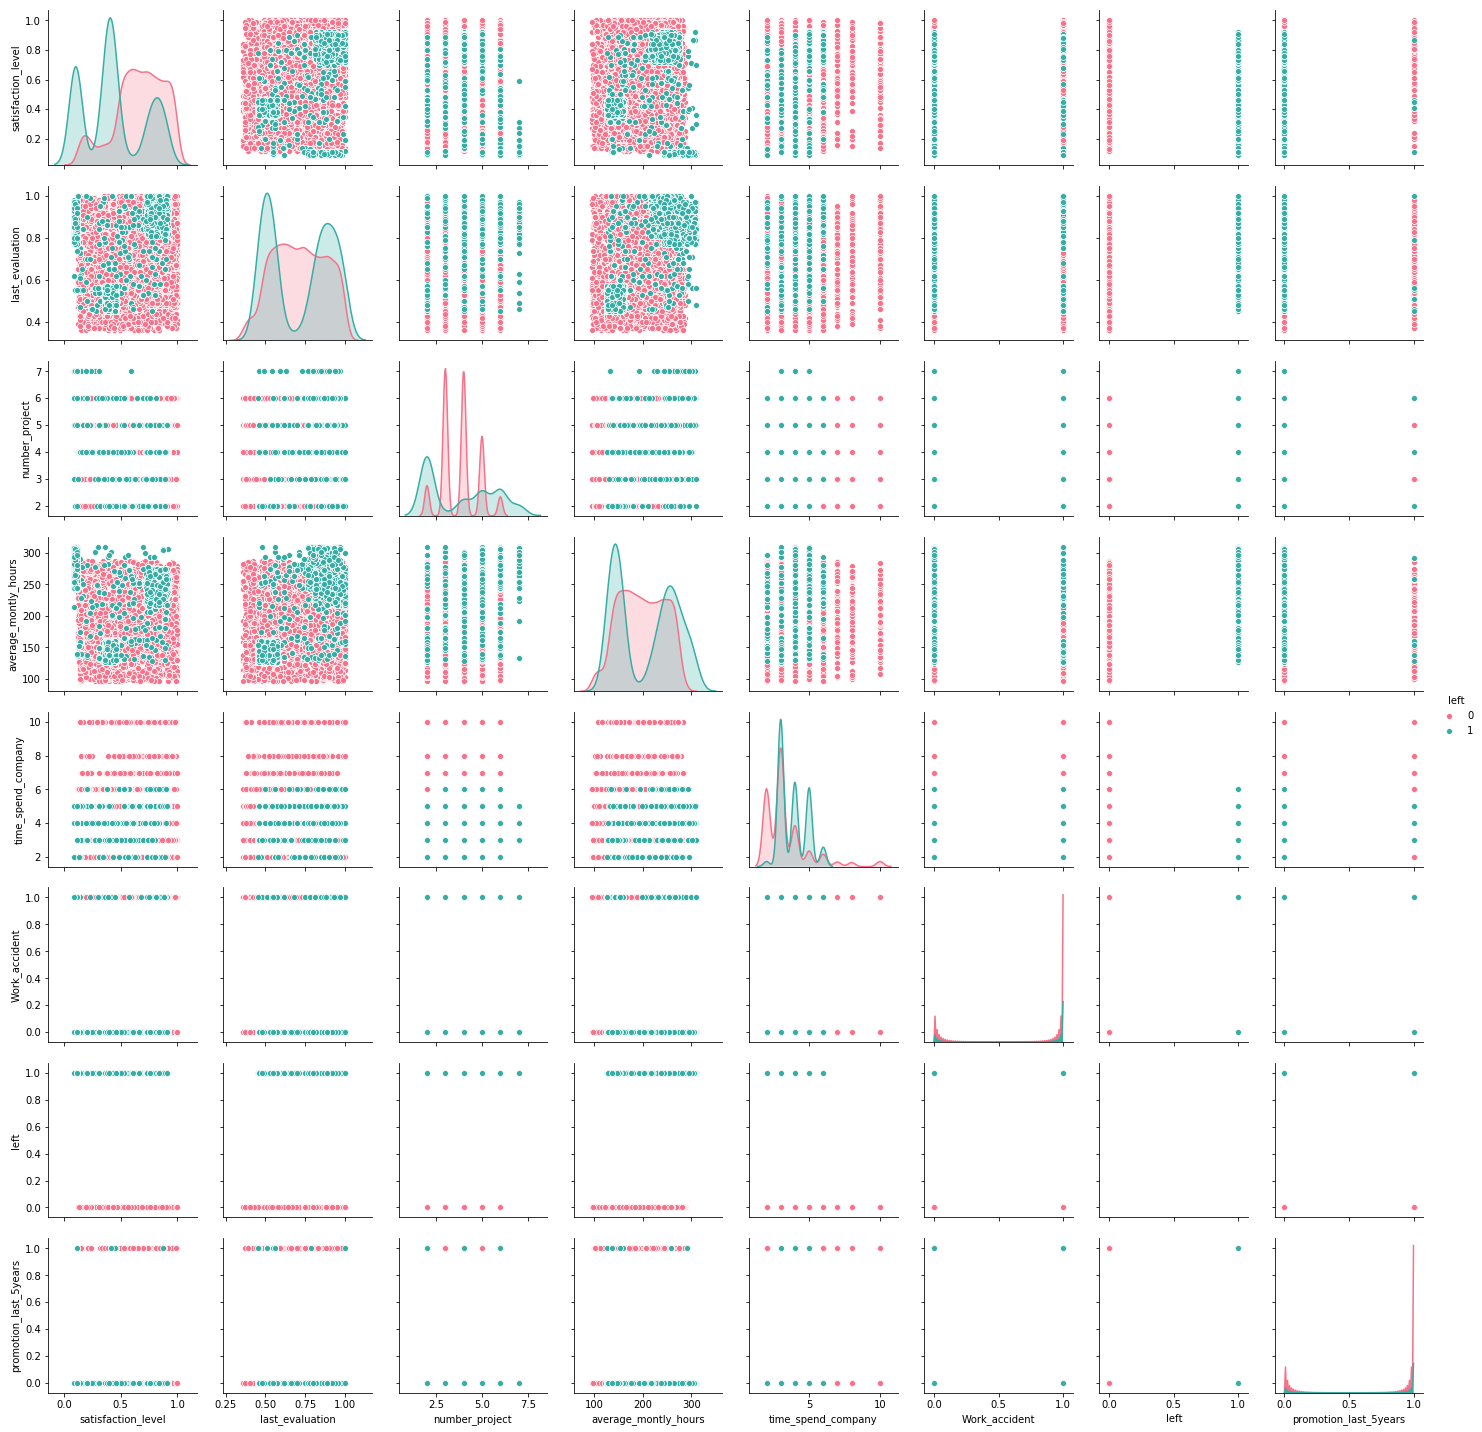

In [9]:
pairplot = sns.pairplot(train_data, hue=KEYS['TARGET'], palette="husl")

### Boxplot of Numerical Variables

We review the distribution of scaled numerical data through a boxplot for each variable.

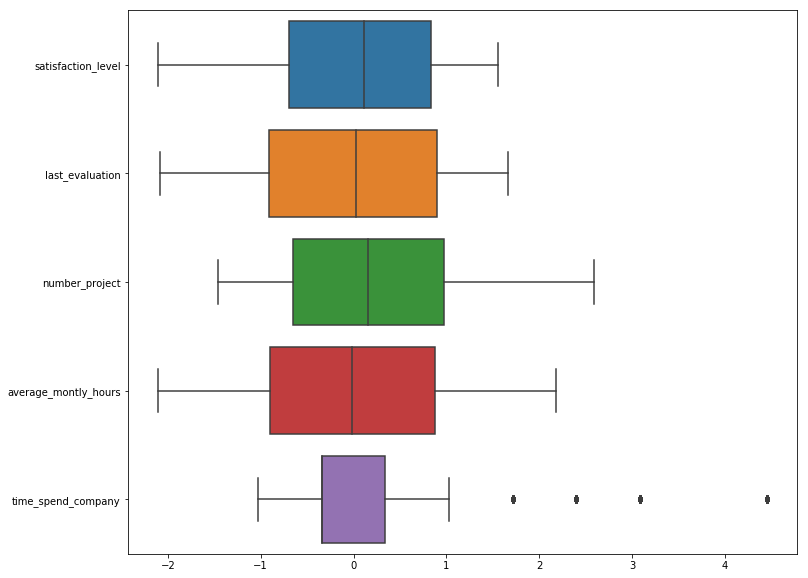

In [10]:
hp.boxplot(data)

### Coefficient of Variation

The coefficient of variation is a dimensionless meassure of dispersion in data, the lower the value the less dispersion a feature has.

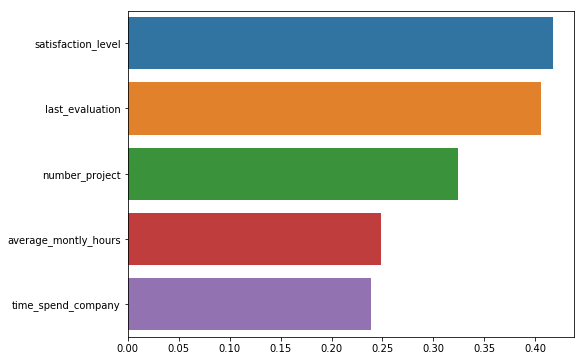

In [11]:
hp.coefficient_v(data)

### Data Correlation

Now we analyze correlation in the data for both numerical and categorical columns and plot them, using a threshold of 70%.

No correlated columns for the  0.7 threshold


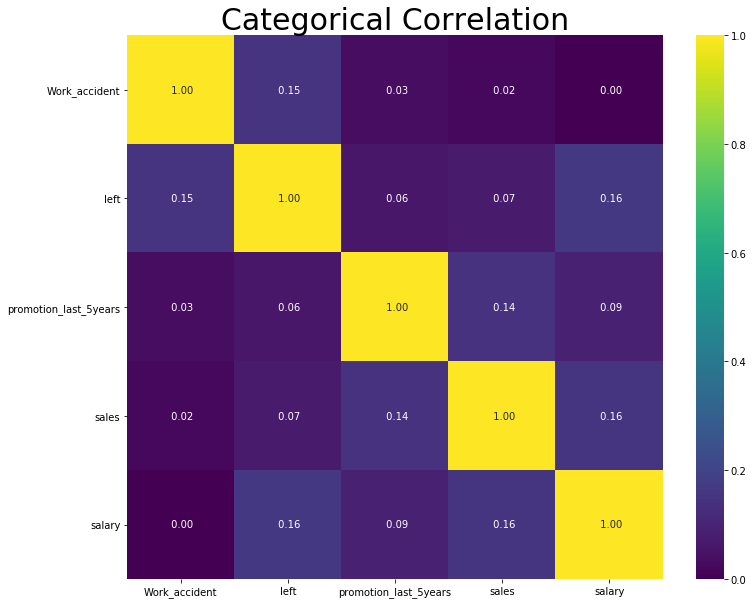

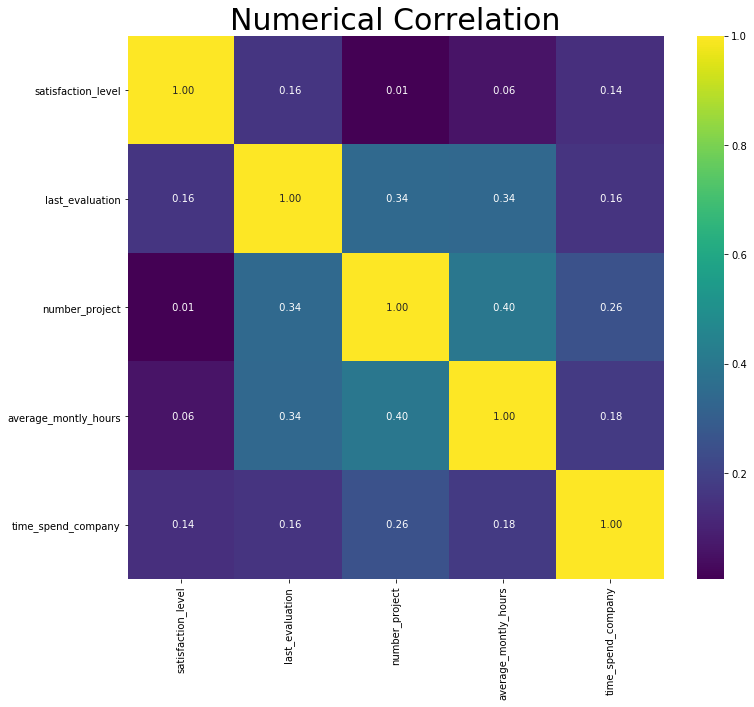

In [12]:
correlated_cols = hp.correlated(train_data, 0.7)

### Underrepresented Features

Now we determine underrepresented features, meaning those that in more than 97% of the records are composed of a single value.

In [13]:
under_rep = hp.under_represented(train_data, 0.97)

['promotion_last_5years'] underrepresented


### Principal Component Analysis (PCA)

We plot PCA component variance to define the number of components we wish to consider in the pipeline.

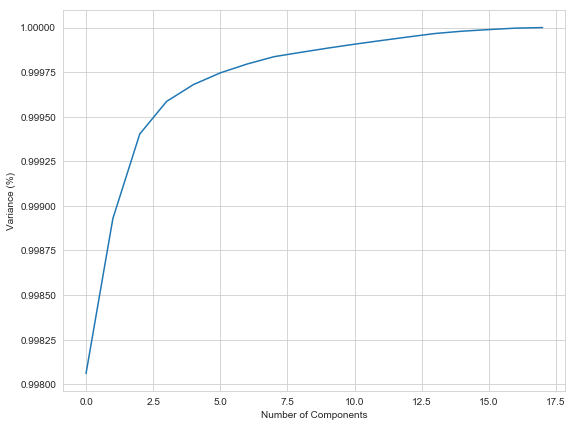

In [18]:
hp.plot_pca_components(data, convert = True)

### Feature Importance

Here we plot feature importance using a random forest in order to get a sense of which features have the most importance.

Feature ranking:


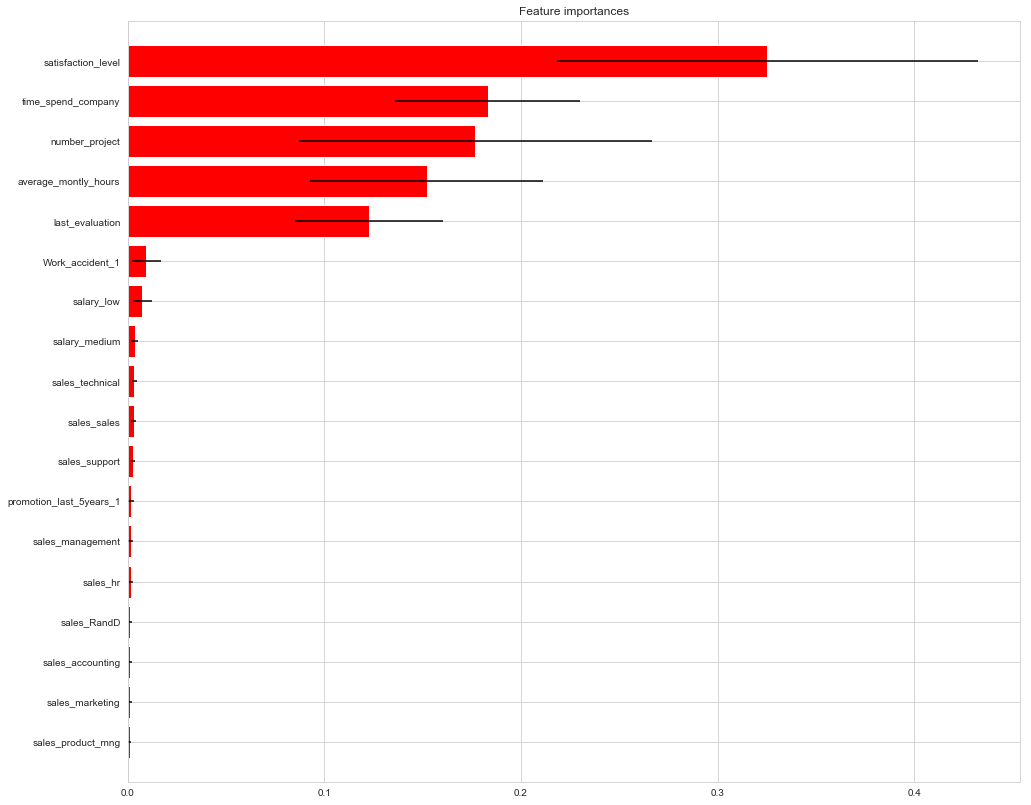

In [19]:
hp.feature_importance(data, RandomForestClassifier(n_estimators=KEYS['ESTIMATORS'], random_state = KEYS['SEED']), convert = True)

### Check target variable balance
We review the distribution of values in the target variable.

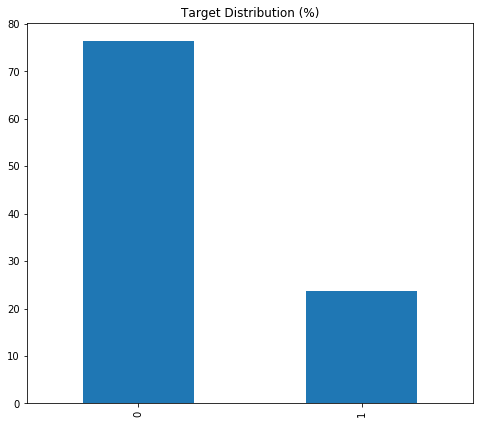

In [45]:
hp.target_distribution(train_data)

Since 0 is employees that stay and 1 is employees that leave, a rebalancing should be tried since there is a very big difference in the number of values for each option.

## Feature Engineering / Pipeline / Modeling

A number of different combinations of feature engineering steps and transformations will be performed in a pipeline with different models, each one will be cross validated to review the performance of the model.

A feature called 'avg_time_per_project' is added to determine the average time each employee spends on a project.

We also try removing unneeded columns, clustering, removing outliers through isolation forests, quantile binning, polynomial combinations, genetic transformations, one hot encoding, rebalancing techniques, recursive feature elimination, feature selection, PCA and more. Each time we see if the scores improve in order to guide our pipeline creation.

In [243]:
def avg_time_pp(df):
    df = df.copy()
    df['avg_time_per_project'] = (df['average_montly_hours'] * 12 * df['time_spend_company'])/ df['number_project']
    df['avg_time_per_project'] = df['avg_time_per_project'].replace([np.inf, -np.inf], np.nan)
    df['avg_time_per_project'] = df['avg_time_per_project'].fillna(0)
    
    return df

def drop_features(df, cols):
    return df[df.columns.difference(cols)]

def kmeans(df, clusters = 3):
    clusterer = KMeans(clusters, random_state=KEYS['SEED'])
    cluster_labels = clusterer.fit_predict(df)
    df = np.column_stack([df, cluster_labels])
    
    return df

def outlier_rejection(X, y):
    model = IsolationForest(random_state=KEYS['SEED'], behaviour='new', n_jobs = -1)
    model.fit(X)
    y_pred = model.predict(X)
    
    return X[y_pred == 1], y[y_pred == 1]

num_pipeline = Pipeline([ 
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize = True)),
#     ('binning', KBinsDiscretizer(n_bins = 5, encode = 'onehot-dense')),
    ('polynomial', PolynomialFeatures(degree = 2, include_bias = False)),
#     ('genetic', SymbolicTransformer(population_size=750, metric='spearman', function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'max', 'min'], parsimony_coefficient = 0.0005, max_samples = 0.9, random_state = KEYS['SEED']))
])

categorical_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

pipe = Pipeline([
    ('avg_time_pp', FunctionTransformer(avg_time_pp, validate=False)),
    ('drop_features', FunctionTransformer(drop_features, kw_args={'cols': correlated_cols + under_rep}, validate=False)),
    ('column_transformer', ColumnTransformer([
        ('numerical_pipeline', num_pipeline, hp.numericals(data, [KEYS['TARGET']]).columns),
        ('categorical_pipeline', categorical_pipeline, ['sales', 'salary']),
    ], remainder='passthrough')),
#     ('kmeans', FunctionTransformer(kmeans, validate=False)),
#     ('outliers', FunctionSampler(func = outlier_rejection)),
#     ('rand_under', RandomUnderSampler(random_state = KEYS['SEED'])),
#     ('ENN_under', RepeatedEditedNearestNeighbours(random_state = KEYS['SEED'])),
#     ('rand_over', RandomOverSampler(random_state = KEYS['SEED'])),
#     ('SMOTE_over', SMOTE(random_state = KEYS['SEED'])),
#     ('combined_sampler', SMOTEENN(random_state = KEYS['SEED'])),
#     ('rfe', RFE(RandomForestClassifier(n_estimators = KEYS['ESTIMATORS'], random_state = KEYS['SEED']), n_features_to_select = 6)),
#     ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators = KEYS['ESTIMATORS'], random_state = KEYS['SEED']), threshold = 0.005)),
#     ('pca', PCA(n_components = 6))
])

models = [
    {'name':'logistic_regression', 'model': LogisticRegression(solver = 'lbfgs', max_iter = KEYS['ITERATIONS'], random_state = KEYS['SEED'])},
    {'name':'random_forest', 'model': RandomForestClassifier(n_estimators = KEYS['ESTIMATORS'], random_state = KEYS['SEED'])},
    {'name': 'extra_tree', 'model': ExtraTreesClassifier(random_state = KEYS['SEED'])}
]

## Scores

Here you can see all of the scores, first with a baseline and then throughout the entire cross validation process for each pipeline, in certain cases errors can happen (for example when a certain fold contains a sparse matrix), therefore you may see errors marked as such in the score.

In [199]:
all_scores = hp.pipeline(train_data, models, pipe, note = 'Base model')

,Model,CV Score,Time,Steps,Note
0,logistic_regression,0.787 +/- 0.008,2.200410,"drop_features, one_hot",Base model
1,random_forest,0.989 +/- 0.002,2.189451,"drop_features, one_hot",Base model
2,extra_tree,0.983 +/- 0.002,0.219959,"drop_features, one_hot",Base model


Here we run the different combinations of pipelines, you may run it multiple times with different parameters and they will be queued.

In [244]:
all_scores = hp.pipeline(train_data, models, pipe, all_scores)

,Model,CV Score,Time,Steps,Note
0,logistic_regression,0.787 +/- 0.008,2.200410,"drop_features, one_hot",Base model
1,random_forest,0.989 +/- 0.002,2.189451,"drop_features, one_hot",Base model
2,extra_tree,0.983 +/- 0.002,0.219959,"drop_features, one_hot",Base model
3,logistic_regression,0.950 +/- 0.004,0.973268,"drop_features, power_transformer, polynomial, one_hot",
4,random_forest,0.989 +/- 0.001,4.401024,"drop_features, power_transformer, polynomial, one_hot",
5,extra_tree,0.987 +/- 0.002,0.356274,"drop_features, power_transformer, polynomial, one_hot",
6,logistic_regression,0.945 +/- 0.012,1.995064,"avg_time_pp, drop_features, power_transformer, polynomial, one_hot, kmeans",
7,random_forest,0.989 +/- 0.001,5.671482,"avg_time_pp, drop_features, power_transformer, polynomial, one_hot, kmeans",
8,extra_tree,0.962 +/- 0.049,0.907744,"avg_time_pp, drop_features, power_transformer, polynomial, one_hot, kmeans",
9,logistic_regression,0.931 +/- 0.004,1.932102,"avg_time_pp, drop_features, power_transformer, polynomial, one_hot, SMOTE_over",


### Pipeline Performance by Model

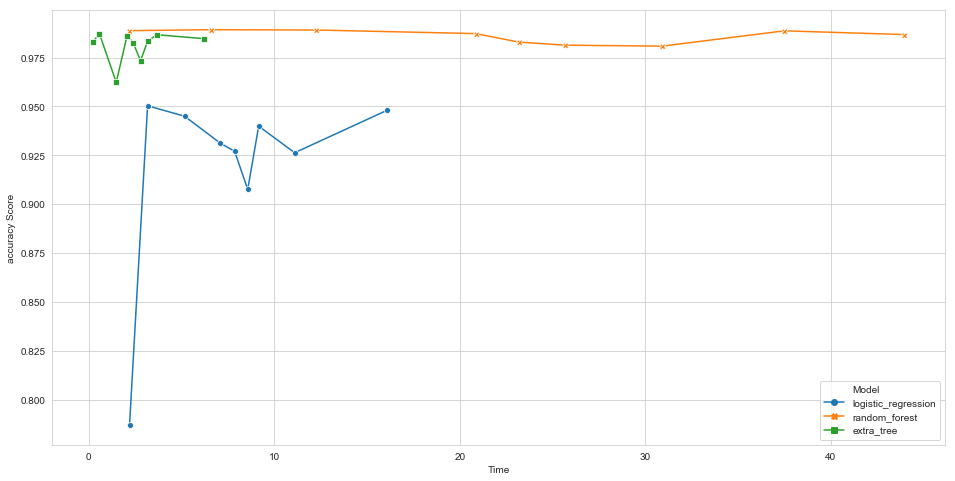

In [245]:
hp.plot_models(all_scores)

### Top Pipelines per Model

Here we show the top pipelines per model.

In [255]:
hp.show_scores(all_scores, top = True)

,CV Score,Time,Steps,Note
Model,,,,
extra_tree,0.987 +/- 0.002,0.356274,"drop_features, power_transformer, polynomial, one_hot",
logistic_regression,0.950 +/- 0.004,0.973268,"drop_features, power_transformer, polynomial, one_hot",
random_forest,0.989 +/- 0.001,4.401024,"drop_features, power_transformer, polynomial, one_hot",


## Randomized Grid Search

Once we have a list of models, we perform a cross validated, randomized grid search on the best performing one to define the final model.

In [248]:
grid = {
    'random_forest__criterion': ['gini', 'entropy'],
    'random_forest__min_samples_leaf': [10, 20],
    'random_forest__min_samples_split': [5, 8],
    'random_forest__max_leaf_nodes': [30, 60],
}

final_scores, grid_pipe = hp.cv_evaluate(train_data, model = clone(hp.top_pipeline(all_scores)), grid = grid)

### Best Parameters for the Model

In [249]:
print(grid_pipe.best_params_)
final_pipe = grid_pipe.best_estimator_

{'random_forest__min_samples_split': 8, 'random_forest__min_samples_leaf': 10, 'random_forest__max_leaf_nodes': 60, 'random_forest__criterion': 'entropy'}


# Results
We evaluate the final model with the holdout, obtaining the definitive score of the model.

In [250]:
y, predictions = hp.predict(train_data, holdout, final_pipe)
score = metric_scorer(y, predictions)
score

0.9716666666666667

## Receiver Operating Characteristic (ROC) / Area Under the Curve 
To review the performance of the model, accuracy is not enough, therefore we plot the ROC of the model on the holdout data.

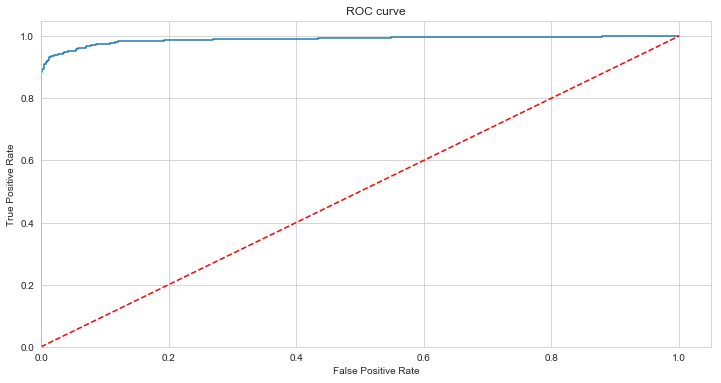

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2239
           1       0.99      0.89      0.94       761

   micro avg       0.97      0.97      0.97      3000
   macro avg       0.98      0.95      0.96      3000
weighted avg       0.97      0.97      0.97      3000



In [251]:
hp.roc(holdout, final_pipe, predictions)

## Stacked Model
Finally, we create a stacked model using the top 2 models obtained during the modeling phase and obtain the holdout results.

In [252]:
stacked, y_stacked, predictions_stacked = hp.stack_predict(train_data, holdout, all_scores, amount = 2)
score_stacked = metric_scorer(y_stacked, predictions_stacked)
score_stacked

0.9896666666666667

In [141]:
print(classification_report(y_stacked, predictions_stacked))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2239
           1       1.00      0.96      0.98       761

   micro avg       0.99      0.99      0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



# Conclusions

The classification report obtained from our stacked model shows its precision (how often the predictions are correct) and the recall (how many of the total observations in the set are correctly classified), also f1-score (combination of both). The weighted average for all of them stands at 99%, it also has an accuracy of 98.96% which means that it can classify which employees will leave the company with great efficacy.

As it was seen in the feature importance step, the most important features in determining employee attrition are their satisfaction level, the number of projects they had, the time spent in the company, their average monthly hours and the score on their last evaluation.

This information is extremely useful to the company and can be used to help them retain their talent and reduce financial losses, first by knowing that these are the factors that they must pay the most attention to, and second, because for each employee, they can obtain an accurate estimation on whether they will leave or not and take the necessary measures to prevent it.